# Evaluate climate projections of different GCM models and scenarios

## Introduction

Nokebook for the workflow **Snakefile_climate_projections**: derives future climate statistics (projected precipitation, temperature, potential evaporation, wind,  change) for different GCMs and scenarios. Monthly gridded change factors are also derived, which can be used to run a hydrological model for future projections based on a delta change approach (this is the topic of the next notebook `docs/notebooks/Hydrological projections.ipynb`).

In [1]:
# Import some python libraries we will need to run this notebook
import os
from IPython import display

In [2]:
# A helper function
from subprocess import Popen, PIPE, STDOUT

from IPython.core.magic import register_line_magic


@register_line_magic
def runrealcmd(command):
    with Popen(
        command, stdout=PIPE, shell=True, stderr=STDOUT, bufsize=1, close_fds=True
    ) as process:
        for line in iter(process.stdout.readline, b""):
            print(line.rstrip().decode("utf-8"))

## Choosing your climate datasets and scenarios

First thing is to prepare all the options for your project, this is done using the configuration or settings file below

In [3]:
# Add here the path where you have installed the blueearth-cst tool
cst_path = r'c:\Users\bouaziz\repos\blueearth_cst'
os.chdir(cst_path)

To chose where the river or basin you want to work with, you will need to supply the location of your river.

The location can either be:
- for a basin to the sea, any point in the basin [x, y]
- for a subbasin (tributary or part of a basin) the location of the subbasin outlet [xout, yout]
- a bounding box [xmin, ymin, xmax, ymax]
- a geometry file of your region of interest (eg, myregion.shp)

The coordinates should be in EPSG 4326.
For points, you can use Google Maps to locate your coordinates.
For bounding box or point cooridnates, you can also copy-paste locations from this website: http://bboxfinder.com/

In [18]:
%%writefile ./config/my-project-settings.yml

########################################################################################
#################################### General settings ##################################

# Path to where the wflow model will be stored (include the project name)
project_dir: examples/myModel

# hydromt "region" for building the model, coordinates are in EPSG 4326
# for more info on how to fill this, please check the hydromt documentation: 
# https://deltares.github.io/hydromt/stable/user_guide/model_region.html#hydrographic-region 
# For wflow please use either 'basin' or 'subbasin' keywords
model_region: "{'subbasin': [12.3758, 46.4076], 'uparea': 70}"

# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
# NB: should in order of priority! 
data_sources: 
  - artifact_data
  - tests/data/tests_data_catalog.yml

# Info on the historical climate data is used in the historic model run + reference data for the weather generator
# Time horizon of the historical period
starttime: "2000-01-01T00:00:00"
endtime: "2010-12-31T00:00:00"

# Historical gridded climate data sources (name as available in the data_sources catalog file). 
clim_historical: 
  - era5
  - chirps_global

#colors to use for plotting (same order as provided in clim_historical)
clim_historical_colors:
  - blue
  - green

    
###########################################################################################
################################## Climate projections ####################################
# climate models and scenarios
clim_project: cmip6
# Path to the data catalog to use (can be different for Linux/Windows/data stored on P drive or other)
data_sources_climate: config/cmip6_data.yml
# Available models: ['NOAA-GFDL_GFDL-ESM4', 'INM_INM-CM4-8' ,'INM_INM-CM5-0','NIMS-KMA_KACE-1-0-G','NCC_NorESM2-MM','NCC_NorESM2-LM','CMCC_CMCC-CM2-SR5','CMCC_CMCC-ESM2']
models: ['NOAA-GFDL_GFDL-ESM4', 'INM_INM-CM5-0', 'CSIRO-ARCCSS_ACCESS-CM2']
# Available scenarios: [ssp126, ssp245, ssp370, ssp585]
scenarios: [ssp245, ssp585]
members: [r1i1p1f1]

# Climate projections for the following variables
variables: [precip, temp, pet]

# Method to compute PET if not available in the climate data - None to use pet in the climate data
# Available methods: 'None', 'makkink' 'debruin', 'penman-monteith_rh_simple', 'penman-monteith_tdew'
# Required variables are: 'temp' [°C], 'press_msl' [hPa], 'kin'[W/m2] for makkink
# 'temp' [°C], 'press_msl' [hPa], 'kin' [W/m2], 'kout' [W/m2] for debruin
pet_method: makkink

# time horizons of the climate projections
start_month_hyd_year: JAN
historical: 2000, 2010
future_horizons: 
  near: 2050, 2060
  far: 2090, 2100

# Additional gridded outputs (else only basin average)
save_grids: TRUE
# Threshold to apply to avoid too large change factors for dry months [mm/month]
change_drymonth_threshold: 3.0
# Maximum change factor for dry months [%]
change_drymonth_maxchange: 50

Overwriting ./config/my-project-settings.yml


## Running the model building workflow

The first line is to create an image of our workflow with snakemake to verify that all our settings are well taken into account.

In [19]:
! snakemake -s snakemake/Snakefile_climate_projections.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_projections.png


Building DAG of jobs...


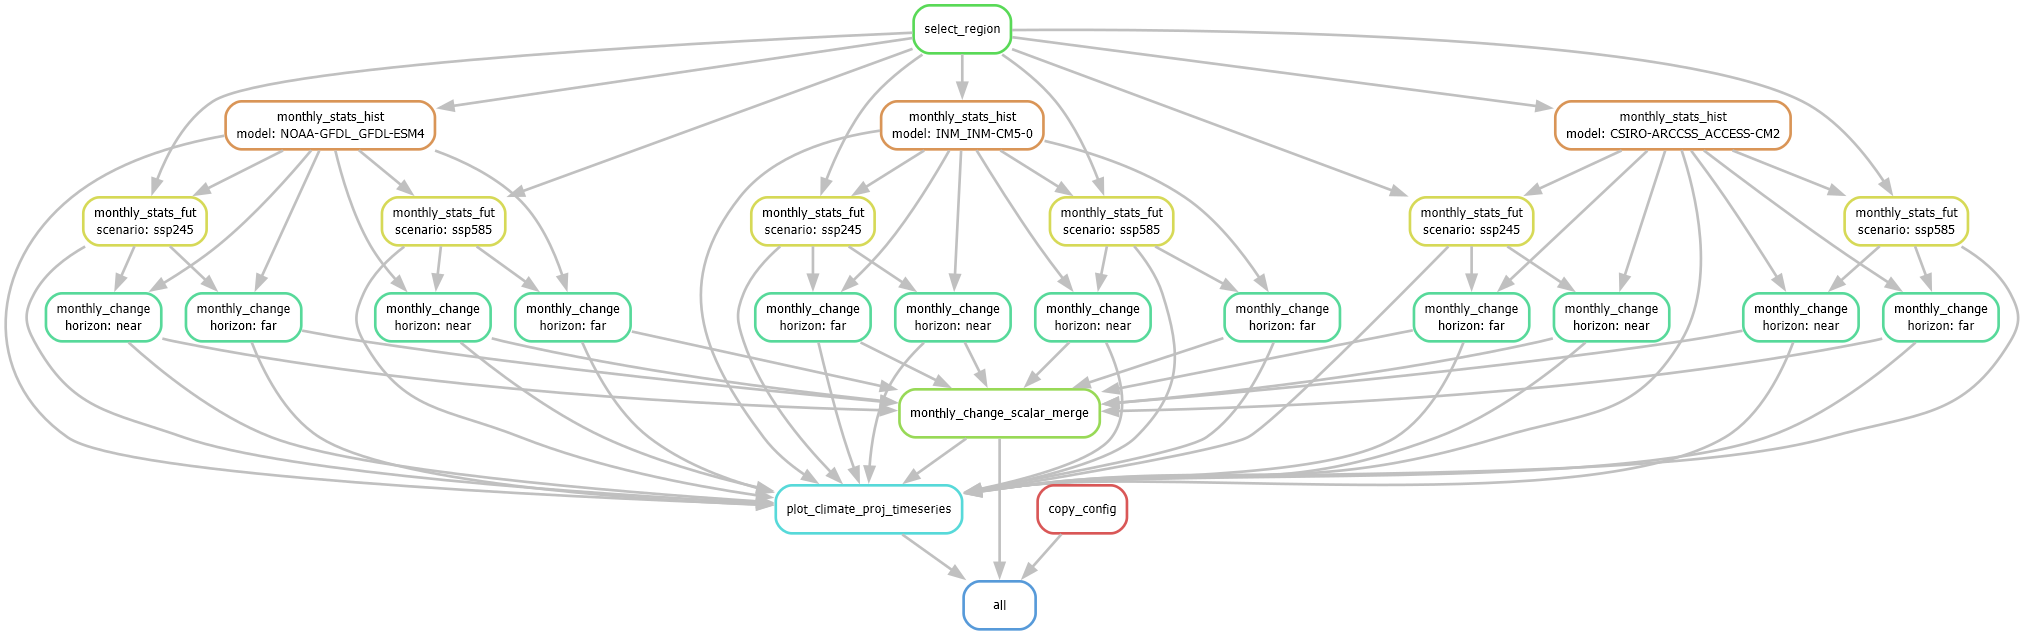

In [20]:
display.Image("./dag_projections.png")

Now we will unlock your directory in order to save the future results of the workflow. This step is most of the time not necessary.

Snakemake also allows us to run a so-called *dryrun*, which will not actually run the workflow, but just print an overview of the rules that will be executed.

In [21]:
! snakemake all -c 1 -s snakemake/Snakefile_climate_projections.smk --configfile config/my-project-settings.yml --dryrun

Building DAG of jobs...
Job stats:
job                             count
----------------------------  -------
all                                 1
copy_config                         1
monthly_change                     12
monthly_change_scalar_merge         1
monthly_stats_fut                   6
monthly_stats_hist                  3
plot_climate_proj_timeseries        1
select_region                       1
total                              26

Execute 2 jobs...

[Wed Sep 18 13:56:11 2024]
localrule select_region:
    output: examples/myModel/region/region.geojson
    jobid: 4
    reason: Missing output files: examples/myModel/region/region.geojson; Params have changed since last execution
    resources: tmpdir=<TBD>


[Wed Sep 18 13:56:11 2024]
localrule copy_config:
    input: config/my-project-settings.yml
    output: examples/myModel/config/snake_config_climate_projections.yml
    jobid: 25
    reason: Missing output files: examples/myModel/config/snake_config_climate_projecti

And finally let's run our worflow:

In [22]:
%runrealcmd snakemake all -c 1 -s snakemake/Snakefile_climate_projections.smk --configfile config/my-project-settings.yml

c:\Users\bouaziz\AppData\Local\mambaforge\envs\blueearth-cst\Lib\subprocess.py:1016: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdout = io.open(c2pread, 'rb', bufsize)


Assuming unrestricted shared filesystem usage.
Building DAG of jobs...
Provided cores: 1 (use --cores to define parallelism)
Rules claiming more threads will be scaled down.
Job stats:
job                             count
----------------------------  -------
all                                 1
copy_config                         1
monthly_change                     12
monthly_change_scalar_merge         1
monthly_stats_fut                   6
monthly_stats_hist                  3
plot_climate_proj_timeseries        1
select_region                       1
total                              26

Select jobs to execute...
Execute 1 jobs...

[Wed Sep 18 13:56:33 2024]
localrule copy_config:
    input: config/my-project-settings.yml
    output: examples/myModel/config/snake_config_climate_projections.yml
    jobid: 25
    reason: Missing output files: examples/myModel/config/snake_config_climate_projections.yml
    resources: tmpdir=C:\Users\bouaziz\AppData\Local\Temp

Copying snake_conf

## Results

First check that snake did run everything.

In [23]:
! snakemake -s snakemake/Snakefile_climate_projections.smk --configfile config/my-project-settings.yml  --dag | dot -Tpng > dag_projections.png

Building DAG of jobs...


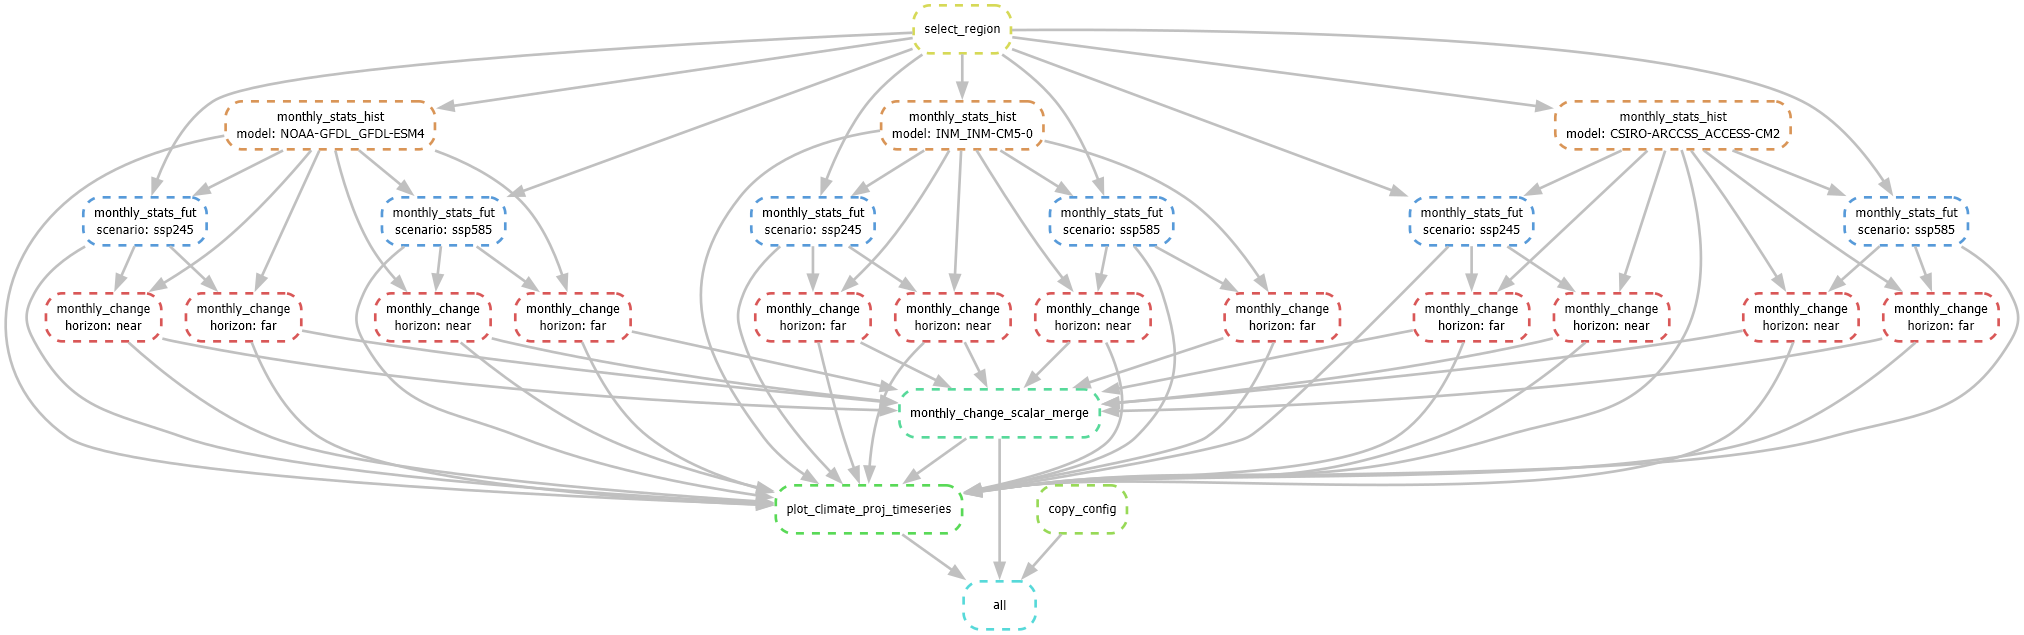

In [24]:
display.Image("./dag_projections.png")

Let's see which files where created in our output folder.

In [25]:
root = "examples/myModel"
for path, _, files in os.walk(root):
    print(path)
    for name in files:
        if name.endswith(".xml"):
            continue
        print(f" - {name}")

examples/myModel
examples/myModel\climate_projections
examples/myModel\climate_projections\cmip6
 - annual_change_scalar_stats_summary.csv
 - annual_change_scalar_stats_summary.nc
 - annual_change_scalar_stats_summary_mean.csv
 - gcm_grid_factors_025.nc
 - gcm_timeseries.nc
examples/myModel\climate_projections\cmip6\monthly_change_grid
 - CSIRO-ARCCSS_ACCESS-CM2_ssp245_far.nc
 - CSIRO-ARCCSS_ACCESS-CM2_ssp245_near.nc
 - CSIRO-ARCCSS_ACCESS-CM2_ssp585_far.nc
 - CSIRO-ARCCSS_ACCESS-CM2_ssp585_near.nc
 - INM_INM-CM5-0_ssp245_far.nc
 - INM_INM-CM5-0_ssp245_near.nc
 - INM_INM-CM5-0_ssp585_far.nc
 - INM_INM-CM5-0_ssp585_near.nc
 - NOAA-GFDL_GFDL-ESM4_ssp245_far.nc
 - NOAA-GFDL_GFDL-ESM4_ssp245_near.nc
 - NOAA-GFDL_GFDL-ESM4_ssp585_far.nc
 - NOAA-GFDL_GFDL-ESM4_ssp585_near.nc
examples/myModel\climate_projections\cmip6\plots
 - gridded_monthly_pet_change_ssp245_far-future-horizon.png
 - gridded_monthly_pet_change_ssp245_near-future-horizon.png
 - gridded_monthly_pet_change_ssp585_far-future-ho

In [26]:
import pandas as pd
df = pd.read_csv('examples/myModel/climate_projections/cmip6/annual_change_scalar_stats_summary_mean.csv')
df

,clim_project,model,member,horizon,scenario,stats,spatial_ref,temp,pet,precip
0,cmip6,CSIRO-ARCCSS_ACCESS-CM2,r1i1p1f1,far,ssp245,mean,0,3.469501,19.505783,1.755634
1,cmip6,CSIRO-ARCCSS_ACCESS-CM2,r1i1p1f1,far,ssp585,mean,0,NaN,NaN,NaN
2,cmip6,CSIRO-ARCCSS_ACCESS-CM2,r1i1p1f1,near,ssp245,mean,0,2.514417,13.064968,8.117418
3,cmip6,CSIRO-ARCCSS_ACCESS-CM2,r1i1p1f1,near,ssp585,mean,0,NaN,NaN,NaN
4,cmip6,INM_INM-CM5-0,r1i1p1f1,far,ssp245,mean,0,2.435583,8.493808,2.588406
5,cmip6,INM_INM-CM5-0,r1i1p1f1,far,ssp585,mean,0,4.503333,14.441259,-5.636344
6,cmip6,INM_INM-CM5-0,r1i1p1f1,near,ssp245,mean,0,1.601666,7.372103,-2.559296
7,cmip6,INM_INM-CM5-0,r1i1p1f1,near,ssp585,mean,0,2.521417,8.829929,-2.289093
8,cmip6,NOAA-GFDL_GFDL-ESM4,r1i1p1f1,far,ssp245,mean,0,2.262416,13.466257,9.405801
9,cmip6,NOAA-GFDL_GFDL-ESM4,r1i1p1f1,far,ssp585,mean,0,4.067000,17.315393,6.557765
